In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

import lightgbm
from lightgbm import LGBMClassifier

In [3]:
train_data = pd.read_csv('traininingdata.txt', sep=';')
test_data = pd.read_csv('testdata.txt', sep=';')

In [4]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


# 1. Preprocessing Data

## 1.1 split job into 4 groups based on label

In [5]:
sort_job=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/len(x)).sort_values(axis=0)
low_level=tuple(sort_job[:4].index.values)
mid_level=tuple(sort_job[4:8].index.values)
advanced_level=tuple(sort_job[8:10].index.values)
high_level=tuple(sort_job[10:].index.values)

In [6]:
train_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)
test_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)

## 1.2 fill 999 for -1 in pdays

In [7]:
train_data.replace({'pdays':{-1:999}}, inplace=True)

## 1.3 Label Encode education, month, poutcome as well as label

In [8]:
train_data.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [9]:
train_data.groupby('poutcome').apply(lambda x: sum(x.y == 'yes') / len(x))

poutcome
failure    0.123765
other      0.169685
success    0.653146
unknown    0.091584
dtype: float64

In [10]:
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
label_dict = {'yes': 1, 'no': 0}
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
poutcome_dict = {'unknown': 0, 'other': 2, 'failure': 1, 'success': 3}

train_data['month'] = train_data.month.apply(lambda x: month_dict[x])
train_data['y'] = train_data.y.apply(lambda x: label_dict[x])
train_data['education'] = train_data.education.apply(lambda x: education_dict[x])
train_data['poutcome'] = train_data.poutcome.apply(lambda x: poutcome_dict[x])

test_data['month'] = test_data.month.apply(lambda x: month_dict[x])
test_data['y'] = test_data.y.apply(lambda x: label_dict[x])
test_data['education'] = test_data.education.apply(lambda x: education_dict[x])
test_data['poutcome'] = test_data.poutcome.apply(lambda x: poutcome_dict[x])


In [11]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,2,divorced,2,no,-78,yes,yes,cellular,29,7,10,23,999,0,0,0
1,50,3,married,3,no,106,yes,no,unknown,15,5,388,2,999,0,0,0
2,47,2,married,2,no,407,yes,no,unknown,5,6,67,12,999,0,0,0
3,39,2,divorced,2,no,952,yes,no,unknown,16,6,62,1,999,0,0,0
4,30,3,single,3,no,364,no,no,cellular,30,4,306,2,999,0,0,1


## 1.4 one-hoe encode marital, default, housing, loan and contact

In [12]:
# one-hot encode job, default, housing, loan, contact
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['marital', 'default', 'housing', 'loan', 'contact']), remainder = 'passthrough').fit(train_data)
train_transformed = transformer.transform(train_data)
test_transformed = transformer.transform(test_data)

train_transformed = pd.DataFrame(train_transformed, columns = transformer.get_feature_names_out())
train_transformed.columns = [i.split('__')[-1] for i in train_transformed.columns]
test_transformed = pd.DataFrame(test_transformed, columns = transformer.get_feature_names_out())
test_transformed.columns = [i.split('__')[-1] for i in test_transformed.columns]

In [13]:
test_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,...,3.0,468.0,14.0,5.0,220.0,1.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,...,3.0,10215.0,22.0,8.0,139.0,2.0,-1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,...,1.0,900.0,9.0,6.0,213.0,1.0,-1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58.0,...,1.0,1231.0,20.0,6.0,21.0,3.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,...,3.0,5301.0,21.0,11.0,937.0,2.0,-1.0,0.0,0.0,1.0


## 1.5 standard-scale all numerical columns

In [14]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# for all other columns, cast to int after scaling
int_features = [i for i in train_transformed.columns if i not in numerical_features]

## 1.6 cast remaining columns to int

In [15]:
train_transformed = train_transformed.astype({i:'int' for i in int_features})
test_transformed = test_transformed.astype({i:'int' for i in int_features})

In [16]:
train_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,0,0,0,1,1,1,0,0,42.0,...,2,-78.0,29,7,10.0,23.0,999.0,0.0,0,0
1,0,1,0,0,1,0,0,0,1,50.0,...,3,106.0,15,5,388.0,2.0,999.0,0.0,0,0
2,0,1,0,0,1,0,0,0,1,47.0,...,2,407.0,5,6,67.0,12.0,999.0,0.0,0,0
3,1,0,0,0,1,0,0,0,1,39.0,...,2,952.0,16,6,62.0,1.0,999.0,0.0,0,0
4,0,0,1,0,0,0,1,0,0,30.0,...,3,364.0,30,4,306.0,2.0,999.0,0.0,0,1


## 1.7 split data

In [17]:
xtrain, xval, ytrain, yval = train_test_split(train_transformed.drop('y', axis = 1), train_transformed['y'], test_size=0.2)
xtest, ytest = test_transformed.drop('y', axis = 1), test_transformed['y']

## 1.8 Downsample Train data to n2p = 5

In [18]:
positive_count = sum(ytrain == 1)
negative_indexes = ytrain[ytrain == 0].sample(n = positive_count * 5, random_state=5101).index
all_indexes = negative_indexes.append(ytrain[ytrain == 1].index)


In [19]:
xtrain_sampled = xtrain.loc[all_indexes,:]
ytrain_sampled = ytrain.loc[all_indexes]

# 1.9 Over Sample traning data using SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.6,random_state=5101)
xtrain_SMOTE, ytrain_SMOTE = smote.fit_resample(xtrain, ytrain)

# 2 Fit Models

## 2.1 Decision Tree Classifier

### 2.1.1 train on unsampled data

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=5101)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(random_state=5101)

In [22]:
dtProba = dt.predict_proba(xval)
dtPred = (dtProba[:, 1] >= 0.4).astype('int')

In [23]:
print('precision:', precision_score(yval, dtPred))
print('recall:', recall_score(yval, dtPred))
print('f1:', f1_score(yval, dtPred))
print('accuracy',accuracy_score(yval, dtPred))

precision: 0.4685230024213075
recall: 0.4685230024213075
f1: 0.4685230024213075
accuracy 0.8786286978158695


### 2.1.2 train on Downsampled Data

In [24]:
dt2 = DecisionTreeClassifier(random_state=5101)
dt2.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(random_state=5101)

In [25]:
dtProba2 = dt2.predict_proba(xval)
dtPred2 = (dtProba2[:, 1] >= 0.4).astype('int')

In [26]:
print('precision:', precision_score(yval, dtPred2))
print('recall:', recall_score(yval, dtPred2))
print('f1:', f1_score(yval, dtPred2))
print('accuracy',accuracy_score(yval, dtPred2))

precision: 0.4216981132075472
recall: 0.5411622276029056
f1: 0.47401908801696707
accuracy 0.8628697815869505


### 2.1.3 train on SMOTE data

In [27]:
dt3 = DecisionTreeClassifier(random_state=5101)
dt3.fit(xtrain_SMOTE, ytrain_SMOTE)

DecisionTreeClassifier(random_state=5101)

In [28]:
dtProba3 = dt3.predict_proba(xval)
dtPred3= (dtProba3[:, 1] >= 0.4).astype('int')

In [29]:
print('precision:', precision_score(yval, dtPred3))
print('recall:', recall_score(yval, dtPred3))
print('f1:', f1_score(yval, dtPred3))
print('accuracy',accuracy_score(yval, dtPred3))

precision: 0.4181256436663234
recall: 0.4915254237288136
f1: 0.45186421814134664
accuracy 0.8638374343378491


### 2.1.4 parameter tuning using downsampled dat

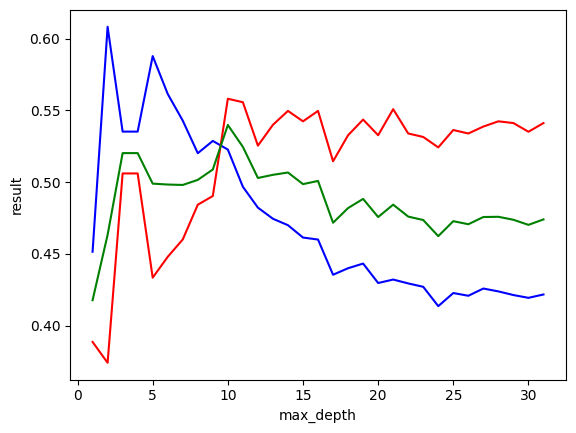

In [30]:
#moudle tuning for max_depths using validation
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = DecisionTreeClassifier(max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

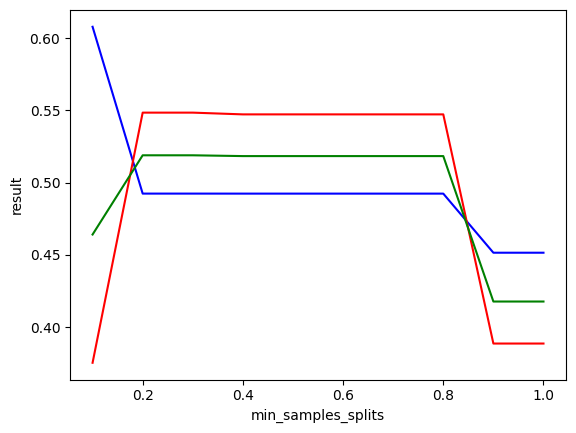

In [31]:
#moudle tuning for min_samples_splits using validation
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = DecisionTreeClassifier(max_depth=10,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

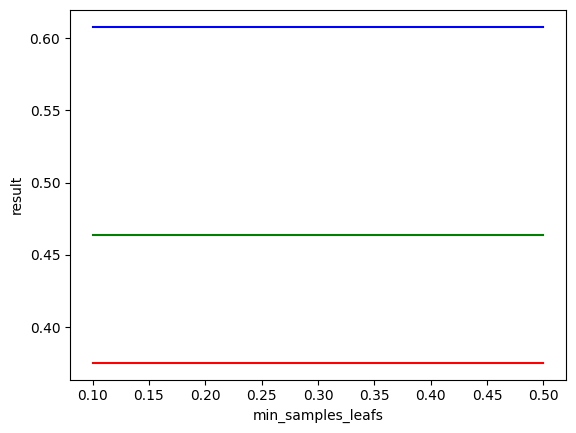

In [32]:
#moudle tuning for min_samples_leafs using validation
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_leaf in min_samples_leafs:
   model = DecisionTreeClassifier(max_depth=10,min_samples_split=0.1,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_leafs, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_leafs, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_leafs')
plt.show()

# this para not cause any influence.

### 2.1.5 Apply new parameters to DCT model

In [33]:
dt4 = DecisionTreeClassifier(max_depth=10,min_samples_split=0.1,random_state=5101)
dt4.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(max_depth=10, min_samples_split=0.1, random_state=5101)

In [34]:
dtProba4 = dt4.predict_proba(xval)
dtPred4 = (dtProba4[:, 1] >= 0.4).astype('int')

In [35]:
print('precision:', precision_score(yval, dtPred4))
print('recall:', recall_score(yval, dtPred4))
print('f1:', f1_score(yval, dtPred4))
print('accuracy',accuracy_score(yval, dtPred4))

precision: 0.4923913043478261
recall: 0.5484261501210653
f1: 0.5189003436426116
accuracy 0.8838816698921759


## 2.2 Random Forest

### 2.2.1 train on unsampled data

In [36]:
RFCls = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
RFCls.fit(xtrain, ytrain)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [37]:
RFProba = RFCls.predict_proba(xval)
RFPrediction = (RFProba[:, 1] >= 0.4).astype('int')

In [38]:
print('precision:', precision_score(yval, RFPrediction))
print('recall:', recall_score(yval, RFPrediction))
print('f1:', f1_score(yval, RFPrediction))
print('accuracy:', accuracy_score(yval, RFPrediction))

precision: 0.5844636251541308
recall: 0.5738498789346247
f1: 0.5791081246182042
accuracy: 0.90475532209013


### 2.2.2 Train on Downsampled Data

In [39]:
RFCls_sampled = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RFCls_sampled.fit(xtrain_sampled, ytrain_sampled)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [40]:
RFProba_sampled = RFCls_sampled.predict_proba(xval)
RFPrediction_sampled = (RFProba_sampled[:, 1] >= 0.4).astype('int')

In [41]:
print('precision:', precision_score(yval, RFPrediction_sampled))
print('recall:', recall_score(yval, RFPrediction_sampled))
print('f1:', f1_score(yval, RFPrediction_sampled))
print('accuracy:', accuracy_score(yval, RFPrediction_sampled))

precision: 0.5424710424710425
recall: 0.6803874092009685
f1: 0.6036519871106337
accuracy: 0.8979817528338402


### 2.2.3 Train on SMOTE Data

In [42]:
RFCls_SMOTE = RandomForestClassifier(random_state=5101, n_estimators=400, max_depth=350, oob_score=True)
RFCls_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

RandomForestClassifier(max_depth=350, n_estimators=400, oob_score=True,
                       random_state=5101)

In [43]:
RFProba_SMOTE = RFCls_SMOTE.predict_proba(xval)
RFPrediction_SMOTE = (RFProba_SMOTE[:, 1] >= 0.4).astype('int')

In [44]:
print('precision:', precision_score(yval, RFPrediction_SMOTE))
print('recall:', recall_score(yval, RFPrediction_SMOTE))
print('f1:', f1_score(yval, RFPrediction_SMOTE))
print('accuracy:', accuracy_score(yval, RFPrediction_SMOTE))

precision: 0.5194444444444445
recall: 0.6791767554479419
f1: 0.5886673662119623
accuracy: 0.8916228918993642


## 2.3 gradient boosting classifier

### 2.3.1 train on unsampled data

In [45]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=5101)
gbc.fit(xtrain, ytrain)

GradientBoostingClassifier(random_state=5101)

In [46]:
gbcProba = gbc.predict_proba(xval)
gbcPred = (gbcProba[:, 1] >= 0.2).astype('int')

In [47]:
print('precision:', precision_score(yval, gbcPred))
print('recall:', recall_score(yval, gbcPred))
print('f1:', f1_score(yval, gbcPred))
print('accuracy',accuracy_score(yval, gbcPred))

precision: 0.4901029295328583
recall: 0.7493946731234867
f1: 0.5926280516993777
accuracy 0.8823610727121924


### 2.3.2 train on Downsampled Data

In [48]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc2 = GradientBoostingClassifier(random_state=5101)
gbc2.fit(xtrain_sampled, ytrain_sampled)

GradientBoostingClassifier(random_state=5101)

In [49]:
gbcProba2 = gbc2.predict_proba(xval)
gbcPred2 = (gbcProba2[:, 1] >= 0.3).astype('int')

In [50]:
print('precision:', precision_score(yval, gbcPred2))
print('recall:', recall_score(yval, gbcPred2))
print('f1:', f1_score(yval, gbcPred2))
print('accuracy',accuracy_score(yval, gbcPred2))

precision: 0.5024630541871922
recall: 0.7409200968523002
f1: 0.598825831702544
accuracy 0.8866463920376002


### 2.3.3 train on SMOTE Data

In [51]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc3 = GradientBoostingClassifier(random_state=5101)
gbc3.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(random_state=5101)

In [52]:
gbcProba3 = gbc3.predict_proba(xval)
gbcPred3 = (gbcProba3[:, 1] >= 0.4).astype('int')

In [53]:
print('precision:', precision_score(yval, gbcPred3))
print('recall:', recall_score(yval, gbcPred3))
print('f1:', f1_score(yval, gbcPred3))
print('accuracy',accuracy_score(yval, gbcPred3))

precision: 0.5013979496738118
recall: 0.6513317191283293
f1: 0.5666140073723013
accuracy 0.8862316837157865


### 2.3.4 parameter tuning using downsampled data 

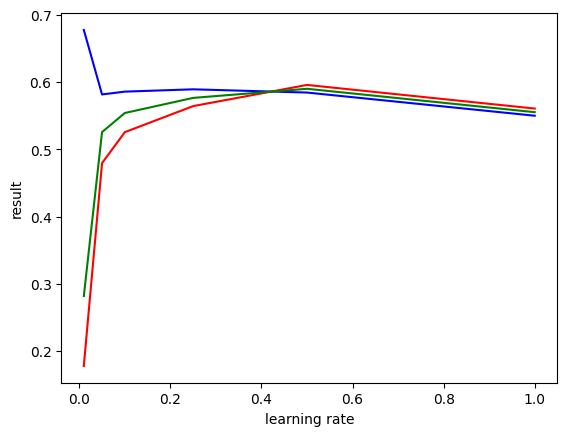

In [54]:
#module tuning for learning rate using validation 
learning_rates = [1,0.5,0.25, 0.1, 0.05,0.01]
precision_result = []
recall_result = []
f1_result = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, precision_result, 'b', label="precision")
line2, = plt.plot(learning_rates, recall_result, 'r', label="recall")
line3, = plt.plot(learning_rates, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('learning rate')
plt.show()

/Users/boyu/.envs/common/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/boyu/.envs/common/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/boyu/.envs/common/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


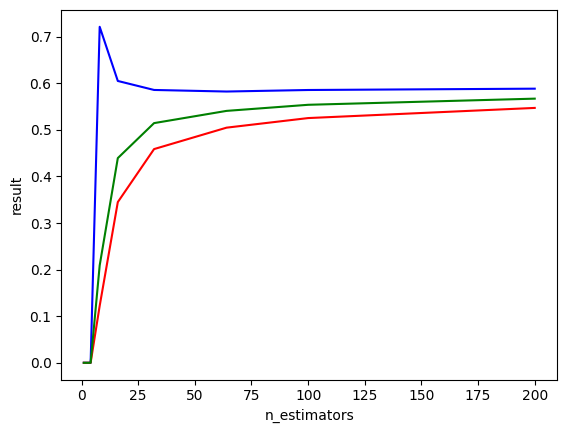

In [55]:
#module tuning for N_estimators using validation 
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
precision_result = []
recall_result = []
f1_result = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=estimator,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, precision_result, 'b', label="precision")
line2, = plt.plot(n_estimators, recall_result, 'r', label="recall")
line3, = plt.plot(n_estimators, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('n_estimators')
plt.show()

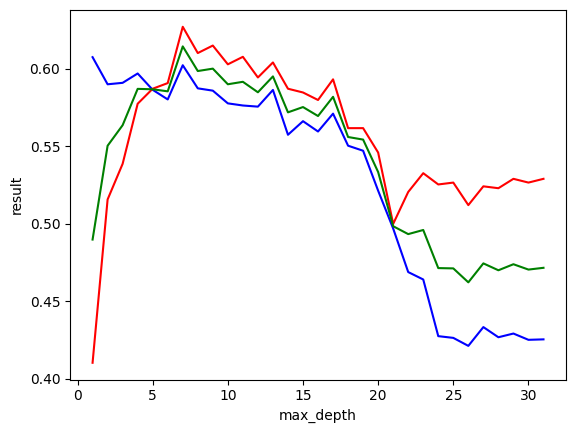

In [56]:
#module tuning for max_depths using validation 
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

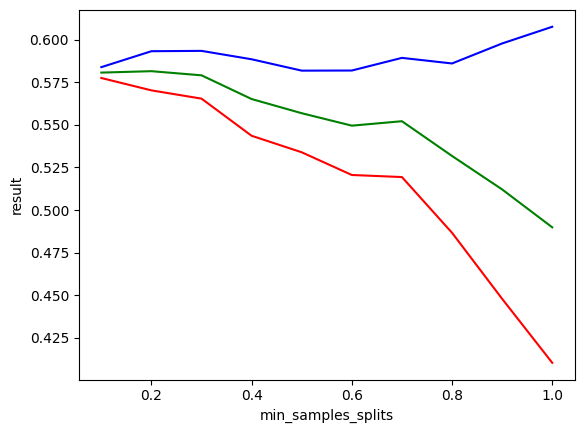

In [57]:
#moduel tuning for min_samples_splits using validation 
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=6,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

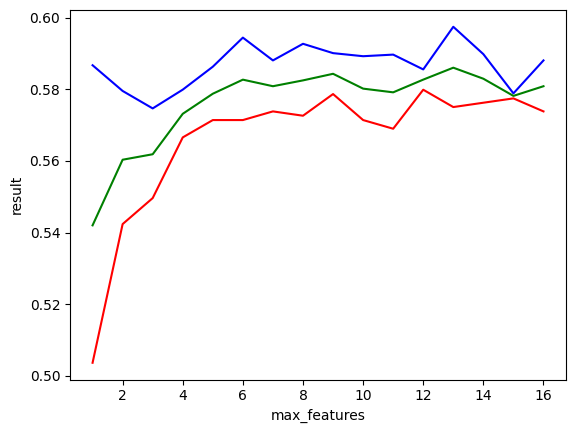

In [58]:
#module tuning for max_features using validation 
max_features = list(range(1,train_data.shape[1]))
precision_result = []
recall_result = []
f1_result = []
for max_feature in max_features:
#  model = GradientBoostingClassifier(learning_rate=0.2,n_estimators=60,max_depth=4,min_samples_split=0.2,max_features=max_feature)
   model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,max_depth=6,min_samples_split=0.1,max_features=max_feature,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   train_pred = model.predict(xtrain_sampled)
   y_pred = model.predict(xval)
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, precision_result, 'b', label="precision")
line2, = plt.plot(max_features, recall_result, 'r', label="recall")
line3, = plt.plot(max_features, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_features')
plt.show()

### 2.3.5 Apply new parameters to GBC model

In [59]:
gbc4 = GradientBoostingClassifier(learning_rate=0.05,n_estimators=80,max_depth=6,min_samples_split=0.1,max_features=11,random_state=5101)
gbc4.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=11,
                           min_samples_split=0.1, n_estimators=80,
                           random_state=5101)

In [60]:
gbcProba4 = gbc4.predict_proba(xval)
gbcPred4 = (gbcProba4[:, 1] >= 0.4).astype('int')

In [61]:
print('precision:', precision_score(yval, gbcPred4))
print('recall:', recall_score(yval, gbcPred4))
print('f1:', f1_score(yval, gbcPred4))
print('accuracy',accuracy_score(yval, gbcPred4))

precision: 0.47573587907716786
recall: 0.7239709443099274
f1: 0.5741718674987998
accuracy 0.8773845728504285


## 2.4 LightGBM

### 2.4.1 Train on original data

In [62]:
lgbm = LGBMClassifier(class_weight='balanced', n_estimators=49, max_depth=300, random_state=5101)
lgbm.fit(xtrain, ytrain)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [63]:
lgbmProba = lgbm.predict_proba(xval)
lgbmPred = (lgbmProba[:, 1] >= 0.7).astype('int')

In [64]:
print('precision:', precision_score(yval, lgbmPred))
print('recall:', recall_score(yval, lgbmPred))
print('f1:', f1_score(yval, lgbmPred))
print('accuracy:', accuracy_score(yval, lgbmPred))

precision: 0.5085158150851582
recall: 0.7590799031476998
f1: 0.6090335114133074
accuracy: 0.8887199336466685


### 2.4.2 Train on downsampled data

In [65]:
lgbm_sampled = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_sampled.fit(xtrain_sampled, ytrain_sampled)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [66]:
lgbmProba_sampled = lgbm_sampled.predict_proba(xval)
lgbmPred_sampled = (lgbmProba_sampled[:, 1] >= 0.7).astype('int')

In [67]:
print('precision:', precision_score(yval, lgbmPred_sampled))
print('recall:', recall_score(yval, lgbmPred_sampled))
print('f1:', f1_score(yval, lgbmPred_sampled))
print('accuracy:', accuracy_score(yval, lgbmPred_sampled))

precision: 0.5089430894308943
recall: 0.7578692493946732
f1: 0.6089494163424125
accuracy: 0.8888581697539397


### 2.4.3 train on SMOTE data

In [68]:
lgbm_SMOTE = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [69]:
lgbmProba_SMOTE = lgbm_SMOTE.predict_proba(xval)
lgbmPred_SMOTE = (lgbmProba_SMOTE[:, 1] >= 0.4).astype('int')

In [70]:
print('precision:', precision_score(yval, lgbmPred_SMOTE))
print('recall:', recall_score(yval, lgbmPred_SMOTE))
print('f1:', f1_score(yval, lgbmPred_SMOTE))
print('accuracy:', accuracy_score(yval, lgbmPred_SMOTE))

precision: 0.4755192878338279
recall: 0.7760290556900726
f1: 0.5896964121435143
accuracy: 0.8766933923140724


# 3. Refit model and check performance on test

In [71]:
# downsample val
positive_count_val = sum(yval == 1)
negative_indexes_val = yval[yval == 0].sample(n = positive_count_val * 5, random_state=5101).index
all_indexes_val = negative_indexes_val.append(yval[yval == 1].index)
xval_sampled = xval.loc[all_indexes_val,:]
yval_sampled = yval.loc[all_indexes_val]

In [72]:
xall = pd.concat([xtrain_sampled, xval_sampled])
yall = pd.concat([ytrain_sampled, yval_sampled])

In [73]:
lgbm_all = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_all.fit(xall, yall)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [74]:
lgbmProba_all = lgbm_sampled.predict_proba(xtest)
lgbmPred_all = (lgbmProba_all[:, 1] >= 0.7).astype('int')

In [75]:
print('precision:', precision_score(ytest, lgbmPred_all))
print('recall:', recall_score(ytest, lgbmPred_all))
print('f1:', f1_score(ytest, lgbmPred_all))
print('accuracy:', accuracy_score(ytest, lgbmPred_all))

precision: 0.49906542056074765
recall: 0.7570888468809074
f1: 0.6015771686068344
accuracy: 0.8826716797522945


In [76]:
RF_all = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RF_all.fit(xall, yall)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [77]:
print('precision:', precision_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('recall:', recall_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('f1:', f1_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('accuracy', accuracy_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))

precision: 0.5230215827338129
recall: 0.6871455576559546
f1: 0.5939542483660131
accuracy 0.8900807254229791


# Feature Importance on Best model

<AxesSubplot: title={'center': 'feature_importance'}, xlabel='feature_score', ylabel='feature_name'>

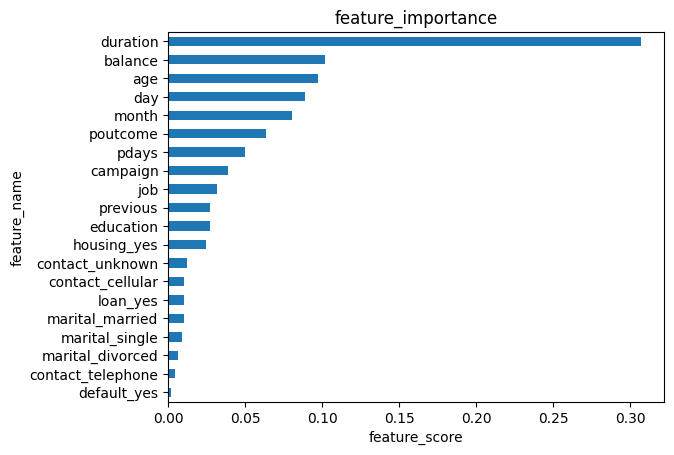

In [78]:
pd.Series(RF_all.feature_importances_, index=RF_all.feature_names_in_).sort_values(ascending=True).plot(kind='barh', xlabel = 'feature_score', ylabel = 'feature_name', title='feature_importance')